In [13]:
!pip install xgboost matplotlib
!python -m spacy download en_core_web_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [14]:
import pandas as pd
from matplotlib import pyplot as plt

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [15]:
power_data = pd.read_csv('artifacts/power_cleaned_data.csv')
power_data.head()

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,53,20:00,7.96,3.38,34.93,45.50,212.74,1.00,1.00,1.00,-0.23,886.17
1,1,53,20:10,8.97,-1.94,34.90,45.54,207.82,1.00,1.00,1.00,-0.21,1071.01
2,1,53,20:20,8.98,5.65,34.85,45.58,220.33,1.00,1.00,1.00,-0.20,1143.00
3,1,53,20:30,8.12,1.19,34.52,45.49,251.20,1.00,1.00,1.00,-0.20,931.46
4,1,53,20:40,5.89,-1.71,34.24,45.46,249.54,0.99,0.99,0.99,-0.24,441.20


In [16]:
class DataCleaner:
    def __init__(self, data):
        self.data = data

    def clean_data(self):
        # Apply all abnormal conditions to filter out invalid data
        conditions = [
            self.data['Patv'] < 0,
            (self.data['Wspd'] < 1) & (self.data['Patv'] > 10),
            (self.data['Wspd'] < 2) & (self.data['Patv'] > 100),
            (self.data['Wspd'] < 3) & (self.data['Patv'] > 200),
            (self.data['Wspd'] > 2.5) & (self.data['Patv'] == 0),
            (self.data['Wspd'] == 0) & (self.data['Wdir'] == 0) & (self.data['Etmp'] == 0),
            self.data['Etmp'] < -21,
            self.data['Itmp'] < -21,
            self.data['Etmp'] > 60,
            self.data['Itmp'] > 70,
            (self.data['Wdir'] > 180) | (self.data['Wdir'] < -180),
            (self.data['Ndir'] > 720) | (self.data['Ndir'] < -720),
            (self.data['Pab1'] > 89) | (self.data['Pab2'] > 89) | (self.data['Pab3'] > 89)
        ]
        
        # Combine all conditions with OR operator
        combined_condition = conditions[0]
        for condition in conditions[1:]:
            combined_condition |= condition
        
        # Filter out rows that meet any of the abnormal conditions
        self.data = self.data[~combined_condition]

        self.data = self.data.dropna()
        return self.data

# Create an instance of the DataCleaner class and clean the data
cleaner = DataCleaner(power_data)
cleaned_data = cleaner.clean_data()


# Display the first few rows of the cleaned dataframe to verify the data is cleaned correctly
cleaned_data.head()

train, test = train_test_split(cleaned_data, test_size=0.5, random_state=42)
train

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
2588,1,78,01:30,3.19,1.74,31.47,40.79,-29.63,0.99,0.99,0.99,-0.25,129.64
269,1,56,04:10,9.58,-4.62,30.39,43.09,8.20,1.00,1.00,1.00,-0.24,1237.39
629,1,58,18:30,7.12,0.09,28.94,39.14,244.08,1.00,1.00,1.00,-0.24,762.42
1730,1,70,22:20,5.99,2.29,35.31,43.90,303.76,1.00,1.00,1.00,-0.24,439.01
1033,1,63,10:50,5.75,0.67,33.88,43.66,75.57,0.99,0.99,0.99,-0.26,437.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,1,64,07:30,7.42,2.84,31.09,38.78,39.67,1.00,1.00,1.00,-0.27,668.30
1294,1,65,14:50,5.66,3.42,39.05,48.34,19.73,1.09,1.09,1.08,-0.02,314.80
860,1,60,15:30,8.62,3.29,38.04,49.27,416.92,1.00,1.00,1.00,-0.31,1061.76
3507,1,86,14:40,6.71,1.91,34.70,44.53,223.51,1.00,1.00,1.00,-0.21,688.53


In [17]:
# encode Tmstamp column to numeric values
train['Tmstamp'] = pd.to_datetime(train['Tmstamp']).astype(int) // 10**9
test['Tmstamp'] = pd.to_datetime(test['Tmstamp']).astype(int) // 10**9

/var/folders/b4/lwfgccm95kqd2skcwvrt2fr00000gn/T/ipykernel_27628/3317315984.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train['Tmstamp'] = pd.to_datetime(train['Tmstamp']).astype(int) // 10**9
/var/folders/b4/lwfgccm95kqd2skcwvrt2fr00000gn/T/ipykernel_27628/3317315984.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test['Tmstamp'] = pd.to_datetime(test['Tmstamp']).astype(int) // 10**9


<Axes: >

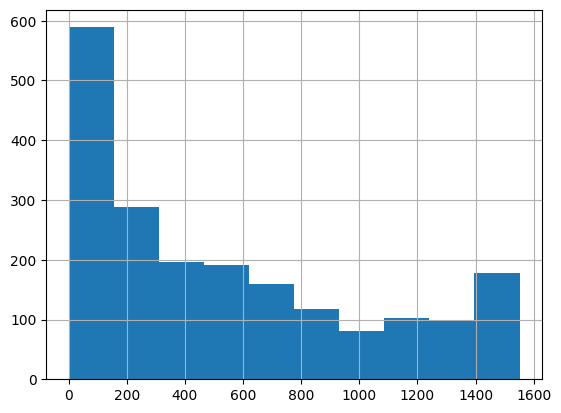

In [18]:
train["Patv"].hist()

<Axes: >

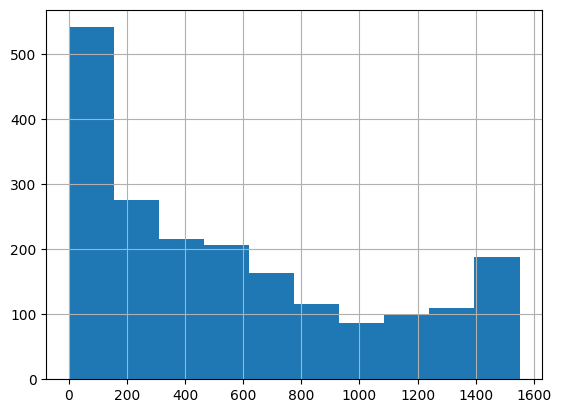

In [19]:
test["Patv"].hist()

In [20]:
# Split the data into training and testing sets
X = train.drop(columns=['Patv'])
y = train['Patv']

X_test = test.drop(columns=['Patv'])
y_test = test['Patv']

# Train an XGBoost model 
original_model = XGBRegressor()
original_model.fit(X, y)

# Make predictions on the test set
y_pred = original_model.predict(X_test)

# Calculate the mean squared error and mean absolute error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 1251.4529064359335
Mean Absolute Error: 20.408584720100553


### GAN synthesized data

In [11]:
train=train.sample(20)

In [21]:
from synthetic_energy.time_series import DGAN, DGANConfig


features = train.to_numpy()
n_time_points = 2
n = features.shape[0] // n_time_points
features = features[: n * n_time_points, :].reshape(
    -1, n_time_points, features.shape[1]
)

config = DGANConfig(max_sequence_len=20, sample_len=5, batch_size=10, epochs=10, cuda=False)
dg = DGAN(config=config)

dg.train_numpy(
    features=features,
)

attributes, features = dg.generate_numpy(n=100)

print(features[0])

2024-12-04 20:40:31 [info     ] Training DGAN model            dtype=dtype('float64') features_length=1000 first_sequence_shape=(2, 13)
2024-12-04 20:40:31 [info     ] Determining outputs metadata from input data
2024-12-04 20:40:31 [info     ] Building DGAN networks        
2024-12-04 20:40:31 [info     ] Checking for nans in the numeric columns number_of_columns=13
2024-12-04 20:40:31 [info     ] Applying linear interpolations for nans (does not mean nans are present)
2024-12-04 20:40:31 [info     ] Creating encoded array of features
2024-12-04 20:40:31 [info     ] Creating encoded array of attributes
2024-12-04 20:40:31 [info     ] Training...                    dtype=dtype('float32') internal_additional_attributes_shape=(1000, 26) internal_attributes_shape=(1000, 1) internal_features_shape=(1000, 20, 13)
2024-12-04 20:40:31 [info     ] Creating TensorDataset        
2024-12-04 20:40:31 [info     ] Calling _train()              
2024-12-04 20:40:31 [info     ] Training              

/Users/ruimelo/anaconda3/envs/phd/lib/python3.10/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


2024-12-04 20:40:33 [info     ] Training                       epoch=1
2024-12-04 20:40:34 [info     ] Training                       epoch=2
2024-12-04 20:40:36 [info     ] Training                       epoch=3
2024-12-04 20:40:38 [info     ] Training                       epoch=4
2024-12-04 20:40:40 [info     ] Training                       epoch=5
2024-12-04 20:40:41 [info     ] Training                       epoch=6
2024-12-04 20:40:43 [info     ] Training                       epoch=7
2024-12-04 20:40:45 [info     ] Training                       epoch=8
2024-12-04 20:40:46 [info     ] Training                       epoch=9
[[ 1.00000000e+00  7.65329518e+01  1.73330297e+09  5.98207804e+00
  -1.31230566e+01  3.49629225e+01  4.00796445e+01  4.13075498e+02
   2.04972874e+00  1.87324764e+00  2.14118904e+00 -1.42731912e-01
   1.33412346e+03]
 [ 1.00000000e+00  6.86195599e+01  1.73330194e+09  3.55974556e+00
  -9.54716175e+00  3.41221543e+01  3.85119323e+01  3.16026194e+02
   9.8907509

In [22]:
import numpy as np
import pandas as pd

# Define the column names
columns = ["TurbID", "Day", "Tmstamp", "Wspd", "Wdir", "Etmp", "Itmp", "Ndir", "Pab1", "Pab2", "Pab3", "Prtv", "Patv"]

# Convert the generated list to a NumPy array
features_array = np.array(features)

# Reshape the array and convert it to a DataFrame
synthetic_df = pd.DataFrame(features_array.reshape(-1, features_array.shape[-1]), columns=columns)

synthetic_df

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1.0,76.532952,1.733303e+09,5.982078,-13.123057,34.962923,40.079644,413.075498,2.049729,1.873248,2.141189,-0.142732,1334.123458
1,1.0,68.619560,1.733302e+09,3.559746,-9.547162,34.122154,38.511932,316.026194,0.989075,0.956009,0.769533,-0.152330,-89.954000
2,1.0,68.077741,1.733296e+09,3.514646,-13.114292,34.034936,38.354592,314.756793,0.997888,0.969862,0.773349,-0.152384,-125.217735
3,1.0,68.059344,1.733296e+09,3.539111,-13.124785,34.020423,38.331165,314.794506,0.991771,0.962287,0.784135,-0.152264,-124.234178
4,1.0,68.069313,1.733296e+09,3.560648,-13.096974,34.023423,38.331858,315.114696,0.994320,0.959953,0.785644,-0.152383,-110.966954
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.0,64.809756,1.733303e+09,4.731927,-28.028941,29.771961,34.213475,-6.230641,0.990793,0.990567,0.972650,-0.298532,278.608878
1996,1.0,64.801372,1.733303e+09,4.723605,-28.026551,29.816588,34.249933,-7.744596,0.990714,0.990561,0.972642,-0.298540,276.876351
1997,1.0,64.789602,1.733303e+09,4.723081,-28.029002,29.776639,34.214922,-7.777715,0.990704,0.990564,0.972633,-0.298542,276.613380
1998,1.0,64.789478,1.733303e+09,4.724203,-28.029029,29.771813,34.213266,-7.780163,0.990702,0.990559,0.972638,-0.298541,276.615322


<Axes: >

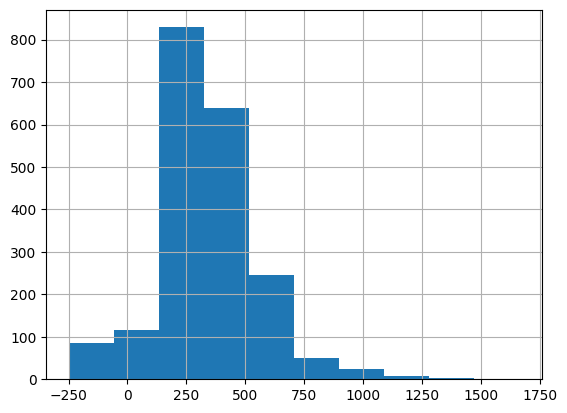

In [23]:
synthetic_df["Patv"].hist()

<Axes: >

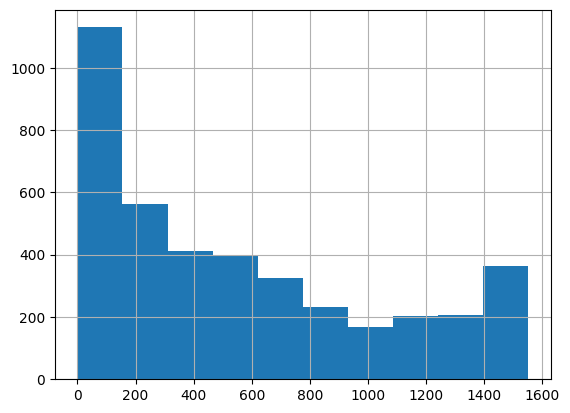

In [24]:
cleaned_data["Patv"].hist()

In [25]:
# Create an instance of the DataCleaner class and clean the data
cleaner = DataCleaner(synthetic_df)
synthesized_cleaned_data = cleaner.clean_data()
# Assuming synthesized_cleaned_data is your DataFrame
synthesized_cleaned_data = synthesized_cleaned_data.astype(float)
synthesized_cleaned_data['Tmstamp'] = pd.to_datetime(synthesized_cleaned_data['Tmstamp']).astype(int) // 10**9

In [26]:
# Split the data into training and testing sets
X_synth_train, X_synth_test = train_test_split(synthesized_cleaned_data, test_size=0.5, random_state=42)

y_synth_train = X_synth_train['Patv']
X_synth_train = X_synth_train.drop(columns=['Patv'])

y_synth_test = X_synth_test['Patv']
X_synth_test = X_synth_test.drop(columns=['Patv'])


# Train an XGBoost model 
synthetic_model = XGBRegressor()
synthetic_model.fit(X_synth_train, y_synth_train)

# Make predictions on the test set
y_pred_synth = synthetic_model.predict(X_synth_test)

# Calculate the mean squared error and mean absolute error
mse = mean_squared_error(y_synth_test, y_pred_synth)
mae = mean_absolute_error(y_synth_test, y_pred_synth)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 3408.5291372535853
Mean Absolute Error: 13.873528241147207


In [27]:
synthetic_df

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1.0,76.532952,1.733303e+09,5.982078,-13.123057,34.962923,40.079644,413.075498,2.049729,1.873248,2.141189,-0.142732,1334.123458
1,1.0,68.619560,1.733302e+09,3.559746,-9.547162,34.122154,38.511932,316.026194,0.989075,0.956009,0.769533,-0.152330,-89.954000
2,1.0,68.077741,1.733296e+09,3.514646,-13.114292,34.034936,38.354592,314.756793,0.997888,0.969862,0.773349,-0.152384,-125.217735
3,1.0,68.059344,1.733296e+09,3.539111,-13.124785,34.020423,38.331165,314.794506,0.991771,0.962287,0.784135,-0.152264,-124.234178
4,1.0,68.069313,1.733296e+09,3.560648,-13.096974,34.023423,38.331858,315.114696,0.994320,0.959953,0.785644,-0.152383,-110.966954
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.0,64.809756,1.733303e+09,4.731927,-28.028941,29.771961,34.213475,-6.230641,0.990793,0.990567,0.972650,-0.298532,278.608878
1996,1.0,64.801372,1.733303e+09,4.723605,-28.026551,29.816588,34.249933,-7.744596,0.990714,0.990561,0.972642,-0.298540,276.876351
1997,1.0,64.789602,1.733303e+09,4.723081,-28.029002,29.776639,34.214922,-7.777715,0.990704,0.990564,0.972633,-0.298542,276.613380
1998,1.0,64.789478,1.733303e+09,4.724203,-28.029029,29.771813,34.213266,-7.780163,0.990702,0.990559,0.972638,-0.298541,276.615322


In [28]:
from synthetic_energy.quality_metrics import (
    WassersteinDistance,
    KLDivergence,
    PopulationStabilityIndex
)




# Calculate the Wasserstein distance between the original and synthetic data
wd = WassersteinDistance()
wd_value = wd(train, synthetic_df)
print(f'Wasserstein Distance: {wd_value}')

# Calculate the Kullback-Leibler divergence between the original and synthetic data
kl = KLDivergence()
kl_value = kl(train, synthetic_df)
print(f'KL Divergence: {kl_value}')

# Calculate the Population Stability Index between the original and synthetic data
psi = PopulationStabilityIndex()
psi_value = psi(train, synthetic_df)
print(f'Population Stability Index: {psi_value}')


Wasserstein Distance: 0.6363333333333334
KL Divergence: 17.362435499304304
Population Stability Index: 26.354414076913237


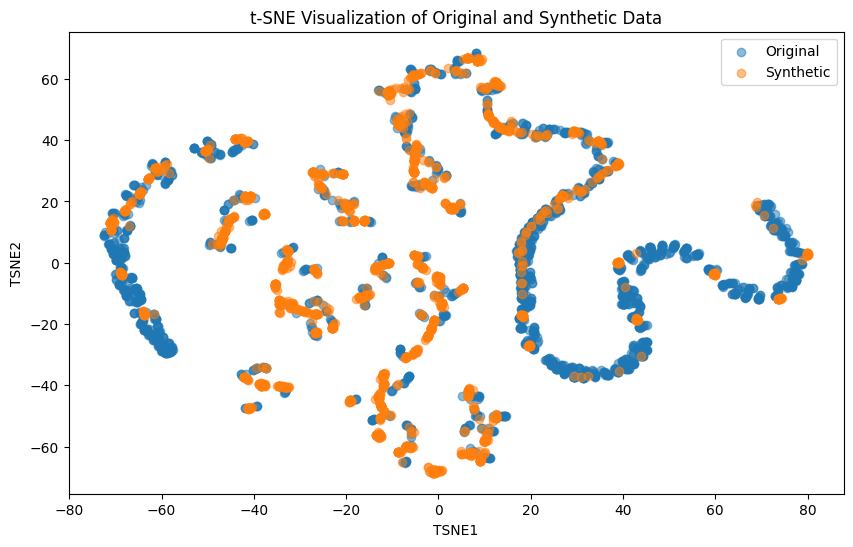

In [29]:
from sklearn.manifold import TSNE

# Combine the original and synthetic data for t-SNE visualization
combined_data = np.vstack((train.values, synthetic_df.values))

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(combined_data)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['label'] = ['Original'] * len(train) + ['Synthetic'] * len(synthetic_df)

# Plot the results
plt.figure(figsize=(10, 6))
for label in tsne_df['label'].unique():
    subset = tsne_df[tsne_df['label'] == label]
    plt.scatter(subset['TSNE1'], subset['TSNE2'], label=label, alpha=0.5)
plt.legend()
plt.title('t-SNE Visualization of Original and Synthetic Data')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()

## Membership Inference Attack

In [30]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# train dataframe was used to train the classifier and test wasnt used. 
# Now the attack model is trained with samples from both train and test labeled as 1 and 0 respectively (0 being the training data)

# Label the data
train['label'] = 1
test['label'] = 0


# Combine the data
attack_data = pd.concat([train, test])

# shuffle the data
attack_data = attack_data.sample(frac=1, random_state=42)

# Split the data into features and labels
X_attack = attack_data.drop(columns=['label'])
y_attack = attack_data['label']

attack_data

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,label
3180,1,83,1733286600,0.88,43.96,31.24,41.60,273.34,1.90,1.90,1.90,-0.30,0.00,1
1459,1,68,1733339400,4.74,3.68,40.12,47.18,172.95,0.99,0.99,0.99,-0.24,262.77,0
1700,1,70,1733329800,4.71,1.97,37.75,44.99,220.96,0.99,0.99,0.99,-0.25,253.91,1
426,1,57,1733301600,10.30,-0.32,31.17,43.79,30.98,1.01,1.01,1.01,-0.24,1429.19,0
2086,1,73,1733356200,7.97,0.61,31.09,43.30,80.64,1.00,1.00,1.00,-0.28,822.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224,1,65,1733281200,7.12,0.26,30.40,41.49,8.81,1.00,1.00,1.00,-0.26,642.09,1
3447,1,86,1733271000,5.07,0.11,30.05,41.37,264.69,0.99,0.99,0.99,-0.24,340.86,1
1755,1,71,1733279400,9.15,2.55,30.76,41.59,384.71,1.00,1.00,1.00,-0.29,1096.68,1
930,1,62,1733332800,2.31,-91.51,37.59,40.70,221.67,1.83,1.83,1.83,0.00,0.00,0


In [31]:
original_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [32]:
# Pass through regressor model to get the predictions
attack_data['Patv'] = original_model.predict(X_attack.drop(columns=['Patv']))
attack_data

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,label
3180,1,83,1733286600,0.88,43.96,31.24,41.60,273.34,1.90,1.90,1.90,-0.30,-0.398874,1
1459,1,68,1733339400,4.74,3.68,40.12,47.18,172.95,0.99,0.99,0.99,-0.24,264.292328,0
1700,1,70,1733329800,4.71,1.97,37.75,44.99,220.96,0.99,0.99,0.99,-0.25,259.772461,1
426,1,57,1733301600,10.30,-0.32,31.17,43.79,30.98,1.01,1.01,1.01,-0.24,1419.949463,0
2086,1,73,1733356200,7.97,0.61,31.09,43.30,80.64,1.00,1.00,1.00,-0.28,849.339600,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224,1,65,1733281200,7.12,0.26,30.40,41.49,8.81,1.00,1.00,1.00,-0.26,648.550842,1
3447,1,86,1733271000,5.07,0.11,30.05,41.37,264.69,0.99,0.99,0.99,-0.24,340.945892,1
1755,1,71,1733279400,9.15,2.55,30.76,41.59,384.71,1.00,1.00,1.00,-0.29,1095.542480,1
930,1,62,1733332800,2.31,-91.51,37.59,40.70,221.67,1.83,1.83,1.83,0.00,5.337205,0


In [33]:
import torch
import torch.nn as nn


class AttackerModel(nn.Module):
    def __init__(self, input_dim):
        super(AttackerModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)
    

# Define the model
attacker_model = AttackerModel(input_dim=X_attack.shape[1])

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(attacker_model.parameters(), lr=0.001)

# Convert the data to PyTorch tensors
X_tensor = torch.tensor(X_attack.values, dtype=torch.float32).view(-1, X_attack.shape[1])
y_tensor = torch.tensor(y_attack.values, dtype=torch.float32).view(-1, 1)


In [34]:

# Train the model
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = attacker_model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

# Get the predictions from the model
predictions = attacker_model(X_tensor).detach().numpy()
predictions = (predictions > 0.5).astype(int)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_attack, predictions)
print(f'Accuracy: {accuracy}')



Epoch 1, Loss: 50.0
Epoch 2, Loss: 50.0
Epoch 3, Loss: 50.0
Epoch 4, Loss: 50.0
Epoch 5, Loss: 50.0
Epoch 6, Loss: 50.0
Epoch 7, Loss: 50.0
Epoch 8, Loss: 50.0
Epoch 9, Loss: 50.0
Epoch 10, Loss: 50.0
Epoch 11, Loss: 50.0
Epoch 12, Loss: 50.0
Epoch 13, Loss: 50.0
Epoch 14, Loss: 50.0
Epoch 15, Loss: 50.0
Epoch 16, Loss: 50.0
Epoch 17, Loss: 50.0
Epoch 18, Loss: 50.0
Epoch 19, Loss: 50.0
Epoch 20, Loss: 50.0
Epoch 21, Loss: 50.0
Epoch 22, Loss: 50.0
Epoch 23, Loss: 50.0
Epoch 24, Loss: 50.0
Epoch 25, Loss: 50.0
Epoch 26, Loss: 50.0
Epoch 27, Loss: 50.0
Epoch 28, Loss: 50.0
Epoch 29, Loss: 50.0
Epoch 30, Loss: 50.0
Epoch 31, Loss: 50.0
Epoch 32, Loss: 50.0
Epoch 33, Loss: 50.0
Epoch 34, Loss: 50.0
Epoch 35, Loss: 50.0
Epoch 36, Loss: 50.0
Epoch 37, Loss: 50.0
Epoch 38, Loss: 50.0
Epoch 39, Loss: 50.0
Epoch 40, Loss: 50.0
Epoch 41, Loss: 50.0
Epoch 42, Loss: 50.0
Epoch 43, Loss: 50.0
Epoch 44, Loss: 50.0
Epoch 45, Loss: 50.0
Epoch 46, Loss: 50.0
Epoch 47, Loss: 50.0
Epoch 48, Loss: 50.0
E